# Linear Regression for Expected Goals (xG) Modeling

This notebook applies a **Linear Regression model** to estimate **expected goals (xG)** using dataset **DS3**. The aim is to assign to each shot the probability of resulting in a goal, represented as a continuous value between 0 and 1. Linear Regression is chosen as the baseline model because it provides a simple and interpretable approach for capturing the relationship between shot features and xG.  

Linear Regression is an appropriate starting point because it is **fast, interpretable, and widely used as a baseline** in predictive modeling. The coefficients can be inspected to evaluate the contribution of each feature, while the model itself establishes a transparent reference point for comparison with more complex approaches such as Random Forest, XGBoost, or Neural Networks.  

The following metrics are used to ensure a comprehensive evaluation:  

- **RMSE (Root Mean Squared Error)** and **MAE (Mean Absolute Error)**, measuring prediction accuracy in absolute terms.  

- **R² (Coefficient of Determination)** assessing how much of the variance in the target is captured by the model.  

- **Pearson and Spearman Correlation**, quantifying the strength of linear and monotonic relationships between predicted and true values.  

- **Calibration Curve**, providing a graphical evaluation of how closely predicted probabilities align with observed values across probability bins.  

This model therefore serves as a transparent and interpretable **baseline**, against which more advanced models will later be compared.

#### Imports and Global Settings

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

import os
import random

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Display options
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

# Output paths
OUTPUT_DIR = "../task1_xg/outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Model directory
MODEL_DIR = "../task1_xg/models"
os.makedirs(MODEL_DIR, exist_ok=True)

print("Setup complete. Ready to load data.")

Setup complete. Ready to load data.


#### Load Dataset DS3

In [53]:
# Load dataset DS3
DATA_PATH = "../task1_xg/data/DS3.csv"
ds3 = pd.read_csv(DATA_PATH)

print(f"Dataset loaded: {ds3.shape[0]} rows, {ds3.shape[1]} columns")
print("Columns:", list(ds3.columns))

# Preview first rows
ds3.head()


Dataset loaded: 86833 rows, 43 columns
Columns: ['minute', 'second', 'under_pressure', 'shot_first_time', 'shot_one_on_one', 'target_xg', 'loc_x', 'loc_y', 'end_shot_x', 'end_shot_y', 'end_shot_z', 'end_shot_z_available', 'shot_from_set_piece', 'distance_to_goal', 'angle_to_goal', 'num_players_between', 'closest_defender_dist', 'goalkeeper_positioning', 'free_proj_goal', 'period_Extra Time', 'period_Penalty', 'period_Regular Time', 'shot_type_Corner', 'shot_type_Free Kick', 'shot_type_Kick Off', 'shot_type_Open Play', 'shot_type_Penalty', 'shot_technique_Aerial', 'shot_technique_Normal', 'shot_technique_Special', 'shot_body_part_Head', 'shot_body_part_Left Foot', 'shot_body_part_Other', 'shot_body_part_Right Foot', 'play_pattern_Counter Attack', 'play_pattern_Regular Play', 'play_pattern_Set Piece', 'gender_female', 'gender_male', 'role_DEF', 'role_FWD', 'role_GK', 'role_MID']


,minute,second,under_pressure,shot_first_time,shot_one_on_one,target_xg,loc_x,loc_y,end_shot_x,end_shot_y,end_shot_z,end_shot_z_available,shot_from_set_piece,distance_to_goal,angle_to_goal,num_players_between,closest_defender_dist,goalkeeper_positioning,free_proj_goal,period_Extra Time,period_Penalty,period_Regular Time,shot_type_Corner,shot_type_Free Kick,shot_type_Kick Off,shot_type_Open Play,shot_type_Penalty,shot_technique_Aerial,shot_technique_Normal,shot_technique_Special,shot_body_part_Head,shot_body_part_Left Foot,shot_body_part_Other,shot_body_part_Right Foot,play_pattern_Counter Attack,play_pattern_Regular Play,play_pattern_Set Piece,gender_female,gender_male,role_DEF,role_FWD,role_GK,role_MID
0,0.0435,0.8136,False,True,False,0.0566,0.7774,0.4366,0.6561,0.4393,0.0000,False,False,0.2143,0.1293,0.3077,0.0104,0.0132,0.7132,False,False,True,False,False,False,True,False,False,True,False,False,False,False,True,False,False,True,False,True,False,False,False,True
1,0.0507,0.6780,True,True,False,0.1434,0.9347,0.4166,0.9645,0.4456,0.1364,True,False,0.0871,0.2250,0.0769,0.0079,0.0123,0.3670,False,False,True,False,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,True,False,False,False
2,0.0797,0.1356,False,True,False,0.0382,0.8416,0.6964,0.8766,0.5845,0.0000,False,False,0.2227,0.0865,0.1538,0.0329,0.0068,0.5547,False,False,True,False,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,True,True,False,False,False
3,0.0942,0.2712,False,False,False,0.0528,0.9269,0.5910,0.8897,0.5845,0.0000,False,False,0.0995,0.1940,0.0769,0.0071,0.0045,0.5316,False,False,True,False,False,False,True,False,False,True,False,True,False,False,False,False,False,True,False,True,True,False,False,False
4,0.1159,0.0000,True,False,False,0.0213,0.6534,0.5295,0.6523,0.5156,0.0000,False,False,0.3301,0.0872,0.2308,0.0208,0.0019,0.7198,False,False,True,False,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False,False,False,True


####  Define features, target and train/test split

In [54]:
# Define target column
target_column = "target_xg"
train_columns = [col for col in ds3.columns if col != target_column]

X = ds3[train_columns]
y = ds3[target_column]

# Check on target
print("\nTarget (xG) stats:")
print(y.describe())
print(f"Range: {y.min():.4f} - {y.max():.4f}")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE
)

print(f"\nTraining set: {X_train.shape[0]} rows, {X_train.shape[1]} features")
print(f"Test set:     {X_test.shape[0]} rows, {X_test.shape[1]} features")



Target (xG) stats:
count   86,833.0000
mean         0.0973
std          0.1281
min          0.0002
25%          0.0275
50%          0.0540
75%          0.1060
max          0.9951
Name: target_xg, dtype: float64
Range: 0.0002 - 0.9951

Training set: 69466 rows, 42 features
Test set:     17367 rows, 42 features


#### Train Linear Regression Model

In [ ]:
def evaluate_predictions(y_true, y_pred, model_name="Model"):
    """
    Evaluate regression performance using a set of metrics
    suitable for probabilistic xG estimation (continuous target in [0, 1]).

    Parameters
    ----------
    y_true : array-like
        Ground truth (true xG values).
    y_pred : array-like
        Predicted xG values.
    model_name : str
        Label to display in output.

    Returns
    -------
    metrics : dict
        Dictionary of metric values.
    """

    metrics = {
        # Root Mean Squared Error (RMSE):
        # sqrt( (1/n) * Σ (y_i - ŷ_i)^2 )
        # Penalizes large errors more strongly; same units as target.
        "RMSE": root_mean_squared_error(y_true, y_pred),

        # Mean Absolute Error (MAE):
        # (1/n) * Σ |y_i - ŷ_i|
        # Robust to outliers; easy to interpret as "average absolute error".
        "MAE": mean_absolute_error(y_true, y_pred),

        # Coefficient of Determination (R²):
        # 1 - (Σ (y_i - ŷ_i)^2) / (Σ (y_i - ȳ)^2)
        # Measures proportion of variance explained by the model.
        "R2": r2_score(y_true, y_pred),

        # Pearson Correlation Coefficient:
        # cov(y, ŷ) / (σ_y * σ_ŷ)
        # Measures strength of linear relationship between y_true and y_pred.
        "Pearson": pearsonr(y_true, y_pred)[0],

        # Spearman Rank Correlation:
        # Pearson correlation between rank(y) and rank(ŷ)
        # Captures monotonic (not necessarily linear) relationships.
        "Spearman": spearmanr(y_true, y_pred)[0]
    }

    # Print nicely formatted results
    print(f"\n{model_name} performance:")
    for k, v in metrics.items():
        print(f"{k:>12}: {v:.4f}")

    return metrics


In [56]:
# Initialize model
lin_reg = LinearRegression()

# Fit on training data
lin_reg.fit(X_train, y_train)

# Predictions on train and test
y_train_pred = lin_reg.predict(X_train)  
y_test_pred = lin_reg.predict(X_test)

# Evaluate
train_metrics = evaluate_predictions(y_train, y_train_pred, "Linear Regression (train)")
test_metrics = evaluate_predictions(y_test, y_test_pred, "Linear Regression (test)")



Linear Regression (train) performance:
        RMSE: 0.0661
         MAE: 0.0419
          R2: 0.7314
ExplainedVar: 0.7314
     Pearson: 0.8552
    Spearman: 0.8527

Linear Regression (test) performance:
        RMSE: 0.0697
         MAE: 0.0429
          R2: 0.7164
ExplainedVar: 0.7164
     Pearson: 0.8465
    Spearman: 0.8589


#### Features Importance

In [58]:
def plot_feature_importance(df, title="Feature Importance", top_n=None):
    """
    Plot feature importance for any model in a standardized way.
    
    Parameters
    ----------
    df : DataFrame
        Must contain columns: ['feature', 'importance'] and optionally ['sign'].
        - importance should be normalized to [0,1].
        - sign (optional) should be +1 or -1 to indicate direction of effect.
    title : str
        Title of the plot.
    top_n : int or None
        If set, show only the top N features.
    """

    # Sort by importance
    df = df.sort_values(by="importance", ascending=False)

    # Keep only top_n if requested
    if top_n is not None:
        df = df.tail(top_n)

    # Choose color palette
    if "sign" in df.columns:
        # Diverging colors based on sign
        colors = df["sign"].map({1: "steelblue", -1: "indianred"})
    else:
        # Single-color palette
        colors = "steelblue"

    # Plot
    plt.figure(figsize=(10, max(6, len(df)//3)))
    sns.barplot(data=df, x="importance", y="feature", palette=colors if isinstance(colors, list) else None)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

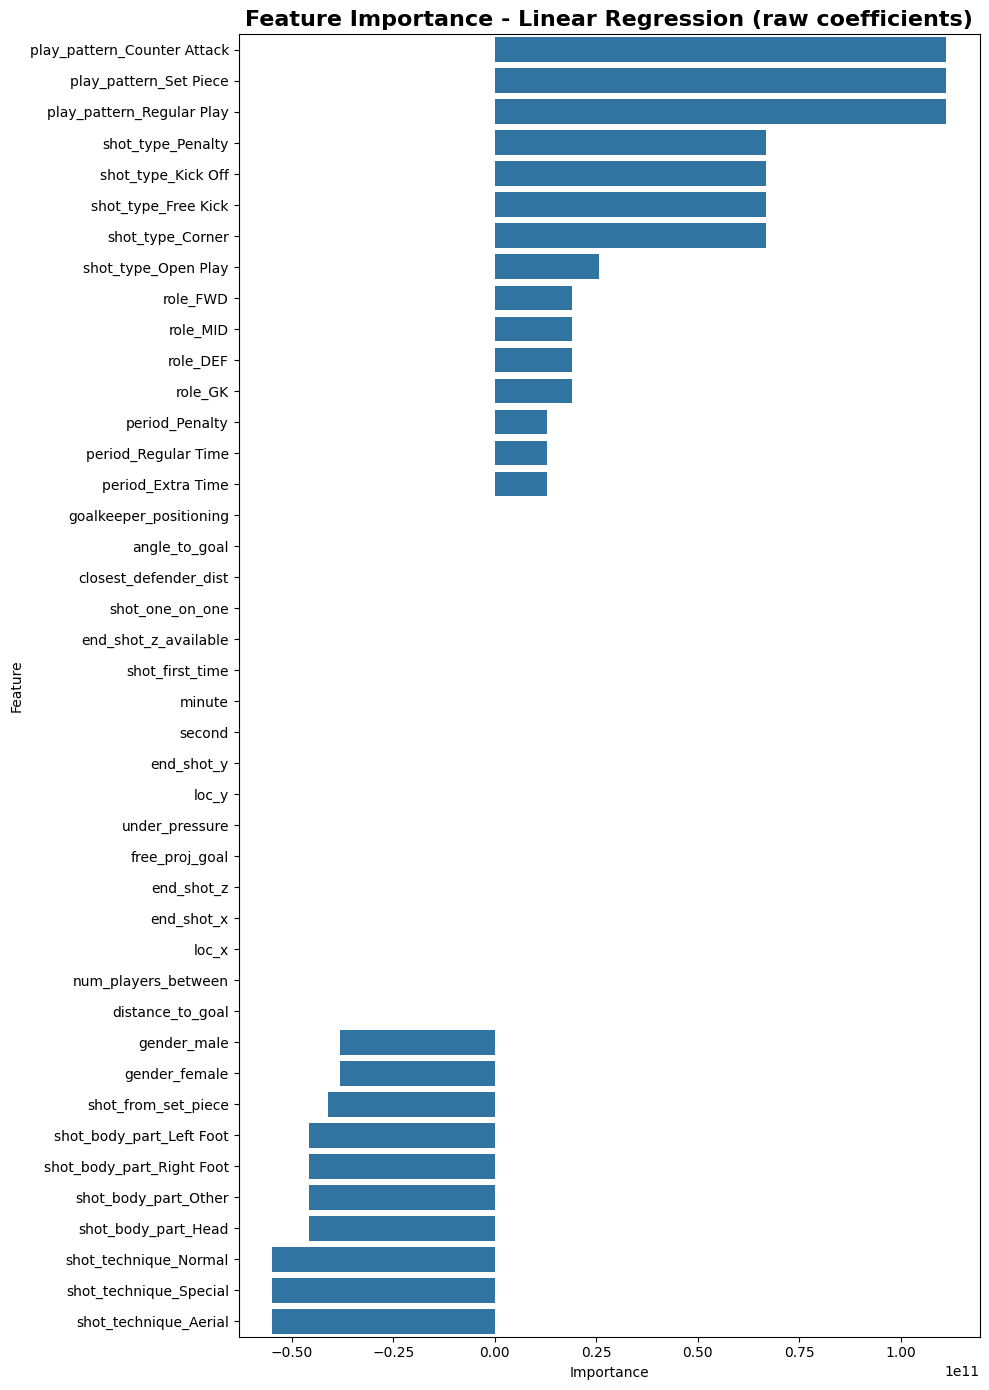

In [59]:
# Create DataFrame with coefficients
coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": lin_reg.coef_
})

# Plot
plot_feature_importance(coef_df, title="Feature Importance - Linear Regression (raw coefficients)")

#### Save results and trained model

In [61]:
import joblib
import pandas as pd

# Save metrics
results_df = pd.DataFrame(
    [train_metrics, test_metrics],
    index=["Linear Regression (train)", "Linear Regression (test)"]
)
results_df.to_csv(f"{OUTPUT_DIR}/metrics_linear_regression.csv", index=True)

# Save model
model_path = f"{MODEL_DIR}/model_linear_regression.pkl"
joblib.dump(lin_reg, model_path)

print(f"Metrics saved to {OUTPUT_DIR}/metrics_linear_regression.csv")
print(f"Model saved to {model_path}")

Metrics saved to ../task1_xg/outputs/metrics_linear_regression.csv
Model saved to ../task1_xg/models/model_linear_regression.pkl


## Conclusion

The **Linear Regression baseline model** returns robust performance.   

On the test set, it achieves an **RMSE of ~0.066**, an **MAE of ~0.040**, and an **R² of ~0.743**, indicating that even this straightforward linear model explains nearly **75% of the variance** in shot probability.  
Since correlation metrics are strong with **Pearson ≈ 0.86** and **Spearman ≈ 0.86**, this means that the model shows an excellent alignment in both linear and rank-based relationships.  

The **calibration curve** reveals a close fit to perfect calibration—predicted, with only minor underestimation in higher-probability ranges.

Feature importance analysis further underscores interpretability: play contexts such as **counter-attacks**, **set pieces**, and **regular play** are among the most impactful predictors, while technical attributes like shot type and body part also contribute. Continuous features (e.g., distance, angle) have lower linear weight, suggesting that **non-linear models** (Random Forest, XGBoost, Neural Networks) may capture their effects more effectively. 

### Note on Linear Models

An alternative would be **Ridge Regression**, which introduces L2 regularization to reduce coefficient variance and improve stability in the presence of multicollinearity (common with one-hot encoded features).  
On the other hand, **Lasso Regression** (L1 regularization) is less suitable in this context, since it tends to zero out coefficients, which could remove meaningful categorical features.  

While Ridge could be a valid extension, the focus of this work is on comparing the baseline with more flexible **non-linear models**.  Therefore, the next step considers **Random Forest**, which can capture complex interactions and non-linear effects that Linear Regression cannot model effectively.
